In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.svm import SVC
from sklearn.inspection import DecisionBoundaryDisplay

sns.set_theme(style="whitegrid")

# The Construction of Custom Kernels for SVMs

In this notebook we will use a synthetic data set to demonstrate the construction of custom kernels for Support Vector Machines. We use a two class data set, where which class a point belongs to is determined by the polar angle of its feature vector. 

In [3]:
n_samples = 1000
X = np.random.randn(n_samples, 2)
angles =  np.arctan(X[:, 1] / (X[:, 0] + 1e-5)) + np.pi * (X[:, 0] < 0)
condition1 = np.logical_and(angles > 0, angles < np.pi/8)
condition2 = np.logical_and(angles > np.pi/2, angles < 5*np.pi/8)
y = np.logical_or(condition1, condition2).astype(int)

# Sample data set to improve class balance

X = np.concatenate([X[y == 1], X[y == 0][::len(y[y == 0])//len(y[y == 1])]])
y = np.concatenate([y[y == 1], y[y == 0][::len(y[y == 0])//len(y[y == 1])]])

Below the decision boundaries of different kernels are shown. We see, that the linear and the polynomial kernel have a hard time separating the two classes. The RBF kernel does a better job, but still does not fully understand the angular dependence.

Kernel: linear


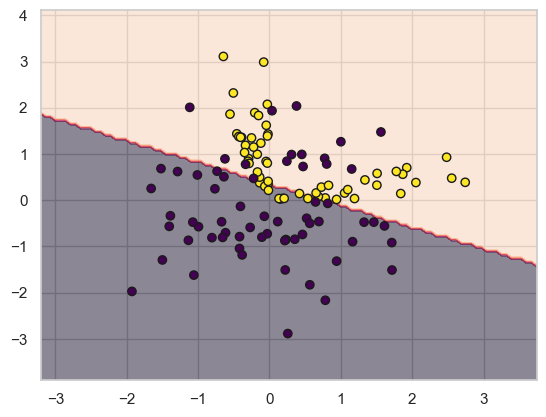

Kernel: poly


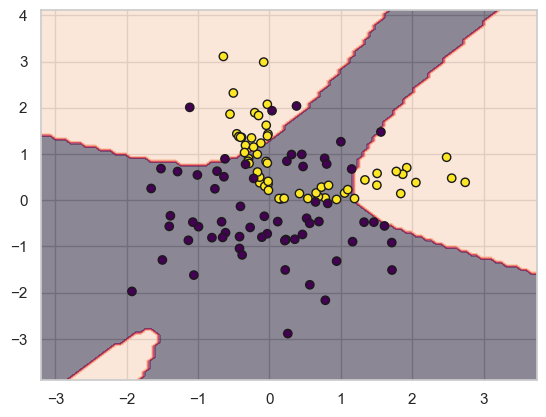

Kernel: rbf


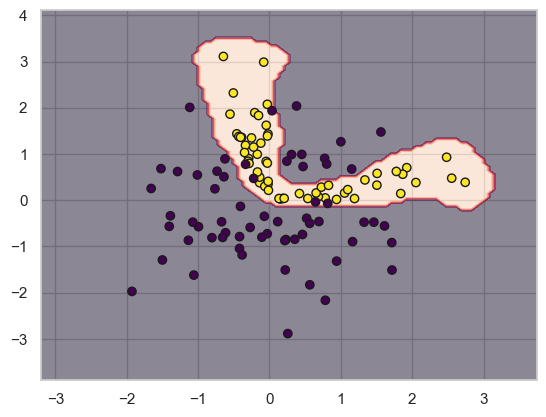

In [4]:
for kernel in ['linear', 'poly', 'rbf']:
    clf = SVC(kernel=kernel, gamma=5 if kernel == 'rbf' else 'auto')
    clf.fit(X, y)

    print(f"Kernel: {kernel}")
    disp = DecisionBoundaryDisplay.from_estimator(clf, X, alpha=0.5, response_method="predict")
    scatter = disp.ax_.scatter(X[::2, 0], X[::2, 1], c=y[::2], edgecolors='k', cmap='viridis')
    plt.show()

To model the angular dependence we use the cosine similarity kernel. Given two feature vectors $x$ and $y$, the cosine similarity kernel returns the cosine of the angle $\theta$ between the two vectors:

$$
\cos{\theta} = \frac{x \cdot y}{\|x\|\|y\|} = \frac{x}{\|x\|} \cdot \frac{y}{\|y\|}
$$

Since the kernel replaces the dot product in SVM's, using the cosine similarity kernel is equivalent to using the linear kernel in a feature space, where the feature vectors are normalized.
This results in cone shaped decision boundaries and helps with the angular dependence, but in this case is not sufficient for the complexity of the data set.

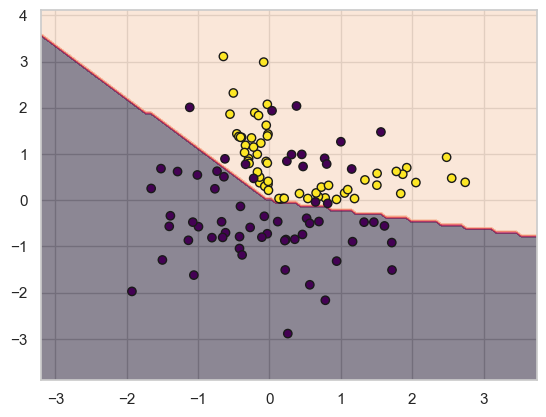

In [5]:
clf = SVC(kernel=cosine_similarity)
clf.fit(X, y)

disp = DecisionBoundaryDisplay.from_estimator(clf, X, alpha=0.5, response_method="predict")
scatter = disp.ax_.scatter(X[::2, 0], X[::2, 1], c=y[::2], edgecolors='k', cmap='viridis')

The RBF kernel uses the euclidean distance to measure the similarity between two points:

$$
k(x, y) = \exp\{-\gamma \cdot \|x-y\|^2\}
$$
with the hyperparameter $\gamma$, determening the influence of a single training example, affecting the smoothness of the decision boundary.

If one assumes two vectors $x$ and $y$ to be normalized the distance between them reduces to 

$$
\|x-y\|^2 = 2\cdot(1-\cos{\theta})
$$

where $\theta$ is the angle between the two vectors. So if we use $2\cdot(1-\mathrm{cosine\_similarity}(x, y))$ as the distance measure in the RBF kernel, that is equivalent to using the RBF kernel in a normalized feature space. This allows us to model complex angular dependencies, like decision bounaries consisting of multiple cones or, in feature spaces with more than two dimensions, deformed cones with cross sections, that no longer have to be circular.

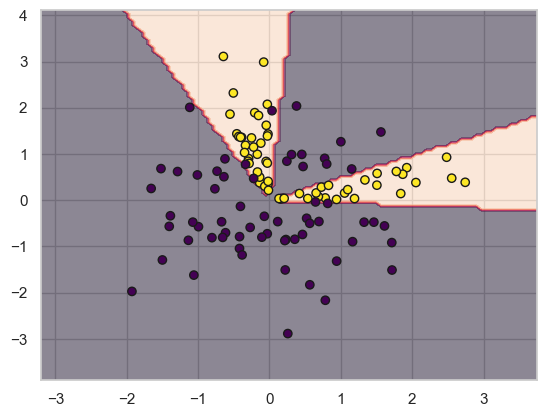

In [6]:
def cosine_rbf_kernel(X, Y=None, gamma=10):
    if Y is None:
        Y = X
    if gamma is None:
        gamma = 1 / X.shape[1]
    return np.exp(-gamma * 2 * (1 - cosine_similarity(X, Y)))

clf = SVC(kernel=cosine_rbf_kernel)
clf.fit(X, y)

disp = DecisionBoundaryDisplay.from_estimator(clf, X, alpha=0.5, response_method="predict")
scatter = disp.ax_.scatter(X[::2, 0], X[::2, 1], c=y[::2], edgecolors='k', cmap='viridis')

But if we now look at the following data set, which also has a strong angular dependence, the cosine_rbf_kernel no longer works well. 

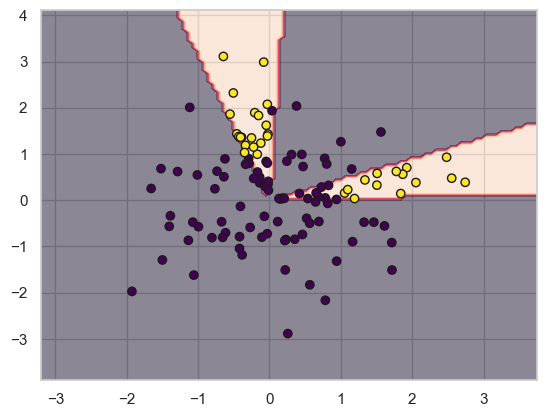

In [7]:
condition3 = np.linalg.norm(X, axis=1) > 1
y_new = np.logical_and(y, condition3).astype(int)

clf = SVC(kernel=cosine_rbf_kernel)
clf.fit(X, y_new)

disp = DecisionBoundaryDisplay.from_estimator(clf, X, alpha=0.5, response_method="predict")
scatter = disp.ax_.scatter(X[::2, 0], X[::2, 1], c=y_new[::2], edgecolors='k', cmap='viridis')

To solve this, we introduce the generalized_cone_kernel, which is a product of the normal RBF kernel and the cosine_rbf_kernel.
The kernel is defined as:
$$
k(x, y) = \exp\{-\gamma \cdot [\alpha \cdot \|x-y\|^2 + (1-\alpha) \cdot 2\cdot(1-\mathrm{cosine\_similarity}(x, y))]\}
$$
The kernels are weighted by a parameter $\alpha$, which can be a function of $x$ and $y$ and has to be chosen according to the specific problem.

For our example we choose $\alpha = \exp\{-\beta (\|x\| + \|y\|)\}$, where $\beta$ is a hyperparameter. This causes the kernel to be more influenced by the cosine similarity for feature vectors with a large magnitude and more influenced by the euclidean distance for feature vectors with a small magnitude.

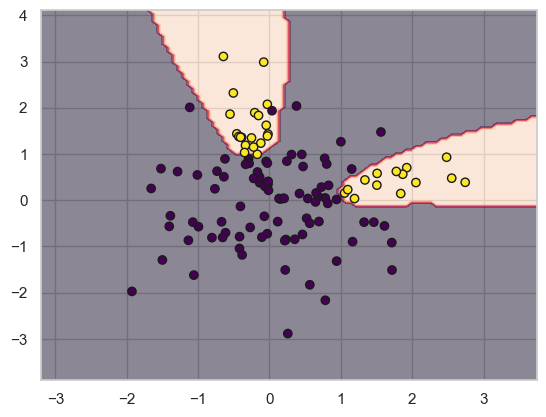

In [8]:
def generalized_cone_kernel(X, Y=None, gamma=10, beta=None):
    if Y is None:
        Y = X
    if gamma is None:
        gamma = 1 / X.shape[1]

    X_norms = np.linalg.norm(X, axis=1)
    Y_norms = np.linalg.norm(Y, axis=1)
    norm_grid = np.meshgrid(X_norms, Y_norms)
    sum_norms = norm_grid[0] + norm_grid[1]

    if beta is None:
        beta =  1 / np.std(sum_norms) 

    alpha = np.exp(-beta * sum_norms).T
    return np.exp(-gamma * (alpha * euclidean_distances(X, Y) + (1 - alpha) * 2 * (1 - cosine_similarity(X, Y))))

clf = SVC(kernel=generalized_cone_kernel, gamma=10)
clf.fit(X, y_new)

disp = DecisionBoundaryDisplay.from_estimator(clf, X, alpha=0.5, response_method="predict")
scatter = disp.ax_.scatter(X[::2, 0], X[::2, 1], c=y_new[::2], edgecolors='k', cmap='viridis')

We see that the use of prior knowledge, here the angular dependence, in constructing a suitable kernel can lead to significant improvements in the capabilities of SVM's.